![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

# Implicit Recommendation from ECommerce Data

Some of the material for this work is based on [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/) by Jesse Steinweg Woods. This tutorial includes an implementation of the Alternating Least Squares algorithm and some other useful functions (like the area under the curve calculation). Other parts of the tutorial are based on a previous version of the Implicit library and had to be reworked.

The dataset used for this work is from Kaggle [E-Commerce Data, Actual transactions from UK retailer](https://www.kaggle.com/carrie1/ecommerce-data)


# Global Imports

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype


# Data Exploration

In [2]:
# It appears that the csv file is encoded as iso-8859-1 (I guessed) and has to be loaded using the encoding parameter.
df = pd.read_csv('../data/external/ecommerce/data.csv', encoding='iso-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
print('Unique invoices', len(pd.unique(df['InvoiceNo'])))
print('Unique products', len(pd.unique(df['StockCode'])))
print('Total rows', len(df))

Unique invoices 25900
Unique products 4070
Total rows 541909


## Checking for missing values

It looks like the InvoiceNo, StockCode, and Quantity are always available. That is all that we will be using from this dataset, so the rest is fine.

In [4]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Let's look at the number of products and see how they are distributed among the orders. We can use the value_counts method from pandas to get an idea of how often each product is ordered.

There are 4070 unique products

Here are the counts of products ordered from largest to smallest
[2313 2203 2159 ...    1    1    1]

And a graph of what the curve looks like:


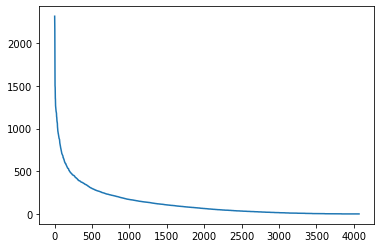

In [5]:
product_counts = df['StockCode'].value_counts().to_numpy()
print('There are', len(product_counts), 'unique products\n')
print('Here are the counts of products ordered from largest to smallest')
print(product_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(product_counts) 
plt.show()

It appears that there are a few items in the store that sell a LOT, and most that are sold a few times. This seems normal for a retail store. Let's take a quick look at the most purchased item to see if it makes sense.

In [6]:
df['StockCode'].value_counts().head()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

In [6]:
df[df['StockCode']=='85123A'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:02,2.55,17850.0,United Kingdom
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:32,2.55,17850.0,United Kingdom
220,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,12/1/2010 10:19,2.55,17511.0,United Kingdom
262,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,12/1/2010 10:39,2.55,13408.0,United Kingdom


We don't have information about the market of the retail store, but looking at a price of 2.55 - this looks like a normal high volume item.

Now we can check the value of each invoice and see what jumps out.

<AxesSubplot:xlabel='InvoiceNo'>

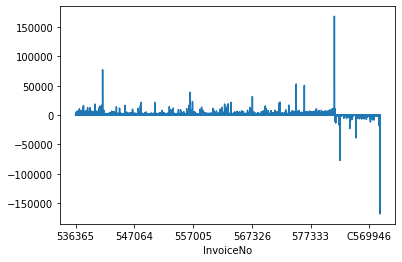

In [7]:
df['StockTotal'] = df['Quantity'] * df['UnitPrice']
totals = df.groupby(df.InvoiceNo)['StockTotal'].sum()
totals.plot()

Well there's something worth looking into. We need to figure out what the negative order totals are. It would have to be either a negative quantity or price - so let's figure out which it is.

In [8]:
print('There are', len(df[df.Quantity < 0]), 'negative quantities')
df[df.Quantity < 0].head()

There are 10624 negative quantities


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockTotal
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96


Now we need to figure out what to do with these. We could throw out all invoices that include negative quanties, or just the items with negative quanties. Let's check to see if we have any mixed invoices.

In [9]:
temp_df = df.groupby(df.InvoiceNo).agg(minQ=('Quantity', 'min'), 
                               maxQ=('Quantity', 'max'))
temp_df[(temp_df.minQ < 0) & (temp_df.maxQ > 0)].head()

,minQ,maxQ
InvoiceNo,,


Given that all negative quantities are on invoices with no purchases, we should be able to remove them.

In [10]:
print('There are', len(df[df.UnitPrice < 0]), 'negative unit prices')

df[df.UnitPrice < 0].head()

There are 2 negative unit prices


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockTotal
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom,-11062.06
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom,-11062.06


It looks like we can throw out anything with a negative UnitPrice.

In [11]:
df = df[(df.UnitPrice > 0) & (df.Quantity > 0)]

Now we need to look into those very large sums on the invoice total to see what is happening there.

In [12]:
totals.sort_values(ascending=False)

InvoiceNo
581483     168469.60
541431      77183.60
574941      52940.94
576365      50653.91
556444      38970.00
             ...    
C580605    -17836.46
C550456    -22998.40
C556445    -38970.00
C541433    -77183.60
C581484   -168469.60
Name: StockTotal, Length: 25900, dtype: float64

In [13]:
df[df.InvoiceNo == '541431'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockTotal
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.6


In [14]:
totals = df.groupby(df.InvoiceNo).sum()
print(len(totals))
quantity_filter = totals[(totals.Quantity <= 100)].index.tolist()
print(len(quantity_filter))

19960
7113


It looks like these were actual orders with a giant quantity. These aren't your average customers, so we may need to try both with the data and without.

Another thing we can do is compute the sparsity of the data. This is useful to see if there is enough overlap between the orders and products to make a useful decision for recommendations.

In [15]:
order_counts = df['InvoiceNo'].value_counts()
num_orders = len(order_counts)
num_items = len(product_counts)
sparsity = 1 - len(df) / (num_orders * num_items)
print(f'number of orders: {num_orders}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

number of orders: 19960, number of items: 4070
matrix sparsity: 0.993475


Compare that with the 100k movielens dataset that has:

```
number of users: 943, number of items: 1682
matrix sparsity: 0.936953
```

Given that this is intended to be used for recommendations based in individual orders, we can remove any invoice that has less than 2 items.

In [16]:
minimum_order_size = 2
order_group = df.loc[:, ['InvoiceNo', 'StockCode']].groupby('InvoiceNo').count()
 
multi_order = order_group[(order_group.StockCode >= minimum_order_size)].count()
single_order = order_group[(order_group.StockCode < minimum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['StockCode'])
print('Orders with less than',minimum_order_size,'products:',single_order['StockCode'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.StockCode >= minimum_order_size)].index.tolist()

Orders with at least 2 products: 18334
Orders with less than 2 products: 1626


In [18]:
filtered_df = df[df['InvoiceNo'].isin(order_filter)].copy()

# Also filter by quantity
filtered_df = filtered_df[filtered_df['InvoiceNo'].isin(quantity_filter)].copy()

print('Original dataframe length:', len(df))
print('Filtered dataframe length:', len(filtered_df))

Original dataframe length: 530104
Filtered dataframe length: 72875


There are 3388 unique products


And a graph of what the curve looks like:


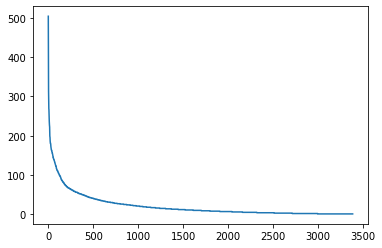

number of orders: 5761, number of items: 3388
matrix sparsity: 0.972841


In [19]:
product_counts = filtered_df['StockCode'].value_counts().to_numpy()
print('There are', len(product_counts), 'unique products\n')
print('\nAnd a graph of what the curve looks like:')
plt.plot(product_counts) 
plt.show()
 
order_counts = filtered_df['InvoiceNo'].value_counts()
num_orders = len(order_counts)
num_items = len(product_counts)
sparsity = 1 - len(df) / (num_orders * num_items)
print(f'number of orders: {num_orders}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

In [20]:
filtered_df['StockCode'] = filtered_df['StockCode'].astype(str)

In [21]:
item_lookup = filtered_df[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) # Encode as strings for future lookup ease

price_lookup = filtered_df[['StockCode', 'UnitPrice']].drop_duplicates()
price_lookup['StockCode'] = price_lookup.StockCode.astype(str)

In [26]:
item_lookup.to_pickle('../data/interim/item_lookup.gz')

In [22]:
selected_df = filtered_df[['InvoiceNo', 'StockCode', 'Quantity']]
selected_df.info()
selected_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72875 entries, 0 to 541893
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   InvoiceNo  72875 non-null  object
 1   StockCode  72875 non-null  object
 2   Quantity   72875 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


,InvoiceNo,StockCode,Quantity
0,536365,85123A,6
1,536365,71053,6
2,536365,84406B,8
3,536365,84029G,6
4,536365,84029E,6


In [23]:
invoices = list(np.sort(selected_df.InvoiceNo.unique())) # Get our unique customers
products = list(selected_df.StockCode.unique()) # Get our unique products that were purchased
quantity = list(selected_df.Quantity) # All of our purchases

cols = selected_df.InvoiceNo.astype(CategoricalDtype(categories=invoices, ordered=True)).cat.codes 
# Get the associated row indices
rows = selected_df.StockCode.astype(CategoricalDtype(categories=products, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity, (rows, cols)), shape=(len(products), len(invoices)))

In [24]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.63446551712478

In [28]:
selected_df.to_pickle(path='../data/interim/selected_invoices.gz')